# Diffusion analysis
(c) Anezka (version 12.12.2024), using Marina's *trc_handling* functions (find in the group wikipedia/ask Anezka for them)

In this code, diffusion properties of the sample are calculated. Using a FOR cycle, analysis can be run over more samples at once.
  
- INPUT (for each sample = each measured well):
    - .h5 data (or use Locator included in this code, to generate your .h5 data)
    - .SPE files

  
- OUTPUT (for each sample = each measured well):
    1) MSD analysis over the whole sample (eg. 10 movies, analyzed together), from which **Mean diffusion coefficient** is defined
    2) MSD analysis over different spots (eg. 10 movies, analyzed separately) in one sample, resulting in plot comparing mean  **Diffusion coefficient** in different spots within one well
    - MSD analysis for individual trajectories in one sample, defining **Individiual diffusion coefficients** in each movie, these are compared in
        3) barplot of diffusion populations
        4) plot of individual diffusion coefficient with respect to trajectory length (number of frames) and their brightness value (assuming there is a correlation between brightness value and presence of aggregation)
        5) example image constructed from one movie, includes 1st frame of the movie and projection of all frames (to study mobility)
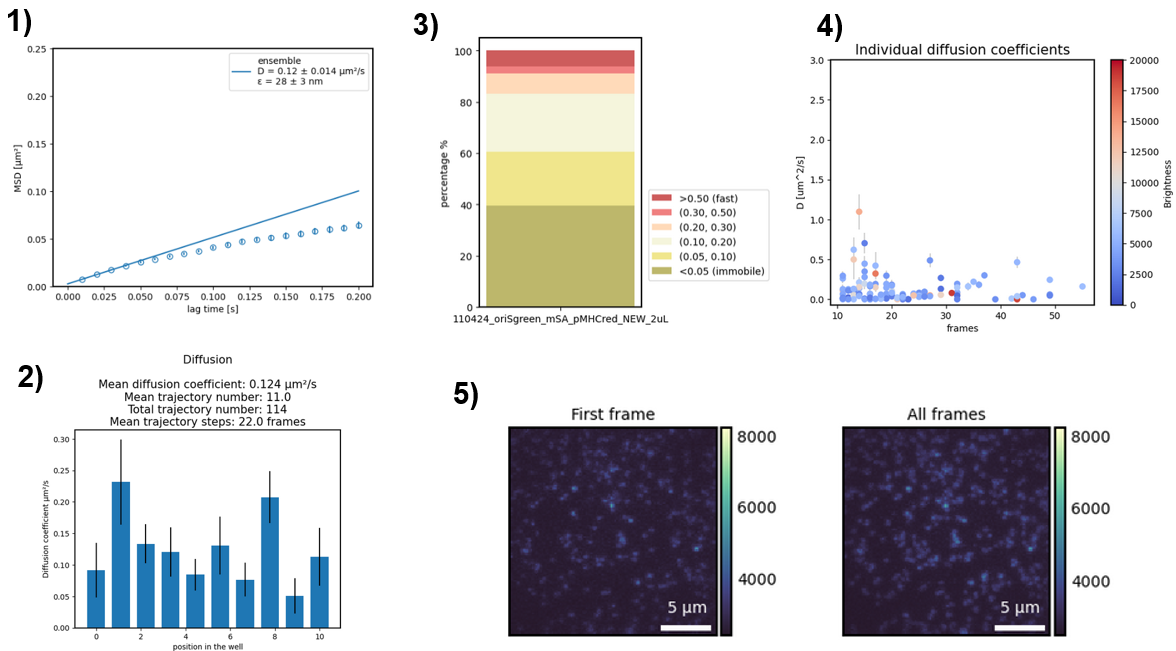


REFERENCE:
- https://schuetzgroup.github.io/sdt-python/
- https://github.com/schuetzgroup/sdt-python

# Packages

In [11]:
from pathlib import Path

import matplotlib.pyplot as plt
plt.close()

import pandas as pd
import pickle

from trc_handling import *



import numpy as np


import ipywidgets
from sdt import io, loc, motion, multicolor, nbui, brightness, roi
import trackpy

trackpy.quiet()
import traitlets

import subprocess
import sys

#for progressbar
from tqdm.notebook import tqdm, trange



import numpy as np
import matplotlib.pyplot as plt
from skimage import io as ios

from pathlib import Path
import seaborn_image as isns
 
 

# user input

- imaging parameters (IMPORTANT! this is based on your imaging procedure, namely illumination time and time delay)
- choose correct thresholds to define diffusion populations
   - if origami sample, set origami=True, else origami=False resulting in thresholds for protein diffusions

In [12]:
#imaging parameters
pixel_size = 0.16 #um
exp_time = 0.003 #s illumination
t_del = 0.007 #s
fps = 1/(t_del+exp_time) #frames per second
 


In [43]:
#tracking parameters
search_range=2.5
memory=2
min_track_length=1
first_frame=10
 

In [33]:
#if origami sample, origami=True, if proteins, origami=False
origami=True

#tresholds
if origami==True:
    immob_thresh =np.log(0.05)  #µm^2/s
    super_slow_tresh=np.log(0.10)
    slow_tresh=np.log(0.20)
    normal_tresh=np.log(0.30)
    fast_tresh=np.log(0.50)

    label_immobile='<0.05 (immobile)'
    label_superslow='(0.05, 0.10)'
    label_slow='(0.10, 0.20)'
    label_normal='(0.20, 0.30)'
    label_middle='(0.30, 0.50)'
    label_fast='>0.50 (fast)'
    
else:
    immob_thresh =np.log(0.05)  #µm^2/s
    super_slow_tresh=np.log(0.5)
    slow_tresh=np.log(1.0)
    normal_tresh=np.log(1.5)
    fast_tresh=np.log(2.5)   

    label_immobile='<0.05 (immobile)'
    label_superslow='(0.05, 0.5)'
    label_slow='(0.5, 1)'
    label_normal='(1,1.5)'
    label_middle='(1.5, 2.5)'
    label_fast='>2.50 (fast)'
 

In [40]:
#localization 
sys.executable
subprocess.run([sys.executable, "-m", "sdt.gui.locator"])
 

/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2025-12-14 13:02:00.392 python[27870:6908859] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'
Exception ignored in: <function Pool.__del__ at 0x162ba1000>

CompletedProcess(args=['/opt/anaconda3/envs/sdt-env/bin/python', '-m', 'sdt.gui.locator'], returncode=0)

In [65]:
#filenames of samples to be analyzed, each filename corresponds to one measured well
filenames=['20251202_24degrees_20ng_slb1_100min', '20251202_24degrees_20ng_slb1_160min', '20251202_24degrees_20ng_slb1_220min', '20251202_24degrees_20ng_slb1_280min', '20251202_24degrees_20ng_slb2_100min', '20251202_24degrees_20ng_slb2_170min', '20251202_24degrees_20ng_slb2_220min', '20251202_24degrees_20ng_slb2_280min']

In [66]:
#data path
data_dir= r'/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/37vs26degrees/origami_37vs26degrees_L1_1202_1204/20251204_origami_24/20ng'
data_loc, data_img= [],[]

#upload the .h5 file data, as a list
#upload the .tiff/.SPE data, as a list of images
for i in filenames:
    data = sorted(Path(data_dir).glob(f'**/{i}*.h5'))
    img_files = sorted(Path(data_dir).glob(f'**/{i}*.tiff')) 
    data_img.append(img_files)
    data_loc.append([io.load(f) for f in data])
    

In [67]:
len(data_img)

8

In [68]:
data_img

[[PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/37vs26degrees/origami_37vs26degrees_L1_1202_1204/20251204_origami_24/20ng/slb1/20251202_24degrees_20ng_slb1_100min_roi_0.tiff'),
  PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/37vs26degrees/origami_37vs26degrees_L1_1202_1204/20251204_origami_24/20ng/slb1/20251202_24degrees_20ng_slb1_100min_roi_1.tiff'),
  PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/37vs26degrees/origami_37vs26degrees_L1_1202_1204/20251204_origami_24/20ng/slb1/20251202_24degrees_20ng_slb1_100min_roi_2.tiff'),
  PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/37vs26degrees/origami_37vs26degrees_L1_1202_1204/20251204_origami_24/20ng/slb1/20251202_24degrees_20ng_slb1_100min_roi_3.tiff'),
  PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/37vs26degrees/origami_37vs26degrees_L1_1202_1204/20251204_origami_24/20ng/slb1/20251202_24degrees_20ng_slb1_100min_roi_4.tiff'),
  PosixPath('/Users/Schor

# Analysis

## Z-projection/all frames stack (quick analysis)


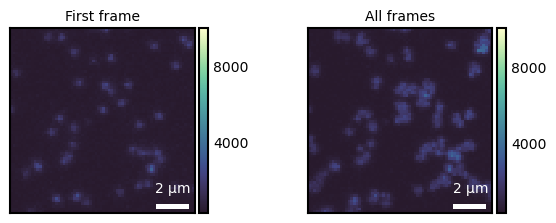

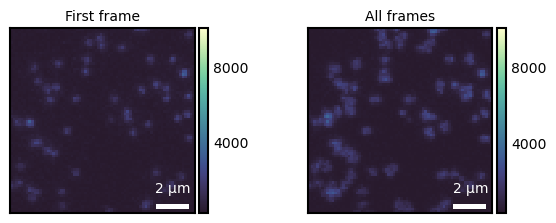

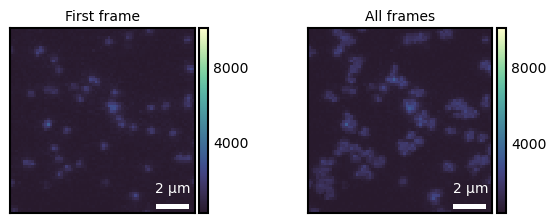

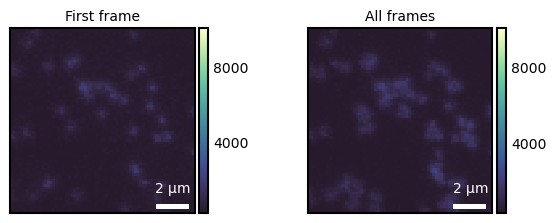

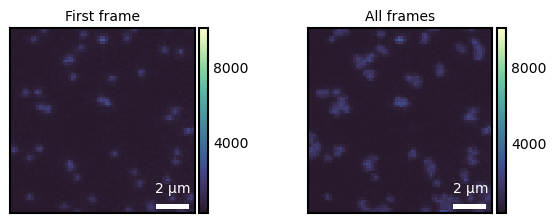

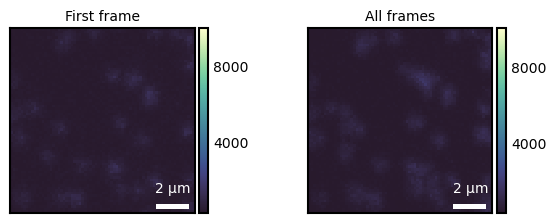

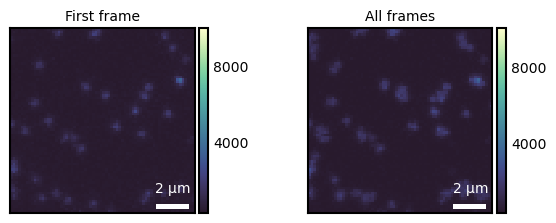

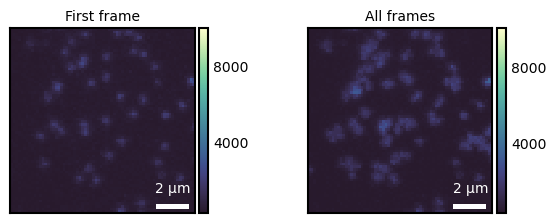

In [69]:
for z in range(0,len(data_img)):


    IM_3rd, IM_MAX=[],[]
    for w in data_img[z]:
        IM = ios.imread(w)
        IM_3rd.append(IM[0])
        #IM_MAX.append(np.max(IM[50:-1], axis=0))
        IM_MAX.append(np.max(IM, axis=0))

    fig, ax = plt.subplots(1, 2)

    isns.imgplot(IM_3rd[-1],vmin=None, vmax= 10000, ax=ax[0], dx=0.160, units='um')#, vmin=-1.2, vmax=1.2,)
    isns.imgplot(IM_MAX[-1],vmin=None, vmax= 10000, ax=ax[1], dx=0.160, units='um')
#ax[1].imshow(IM_MAX[1],vmin=None, vmax= 4200)
    plt.subplots_adjust(wspace=0.5)

    ax[0].set_title('First frame', size=10)
    ax[1].set_title("All frames", size=10)

    fig.savefig(f'{data_dir}/'+filenames[z]+"_Zstack_dif_scale.png")
     

## Tracking

In [70]:
trc,msd_ens,eps,msd_ind,fit_ind=[],[],[],[],[]
D,D_err,eps,eps_err=[],[],[],[]

for i in tqdm(range(0, len(filenames))):
    trc_all=[]
    for j in tqdm(range(0,len(data_loc[i]))):
        
        # tracking
       # if data_loc[i].empty == False:
       # trc_filter.append(trackpy.link(data_loc_roi[i], search_range=search_range, memory=memory))
        trc_all.append(trackpy.link(data_loc[i][j][data_loc[i][j]['frame']>first_frame], search_range=search_range, memory=memory))
   
    #filter your data by the chosen minimal track length (in steps)
    trc.append(min_track_filter(trc_all, min_track_length=min_track_length))
    
    #msd analysis for all trajectories
    msd_ens.append(motion.Msd(trc[i], fps, pixel_size=pixel_size, ensemble=True).fit("brownian", exposure_time=exp_time))
    eps.append(msd_ens[i].get_results()[0]['eps'])

    #msd analysis for individual trajectories  
    msd_ind.append(motion.Msd(trc[i], fps, pixel_size=pixel_size, ensemble=False))
    fit_ind.append(BrownianMotionFixedEps(msd_ind[i]._msd_data, eps[i], n_lag=2))
 

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## MSD analysis: mean diffusion coefficient

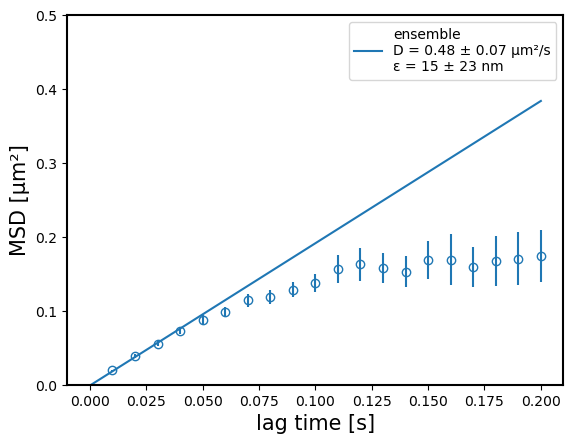

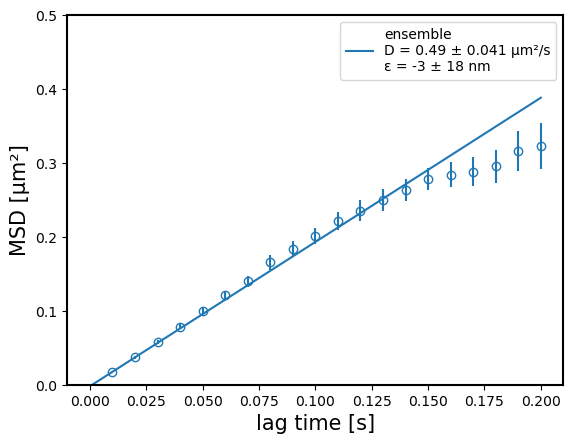

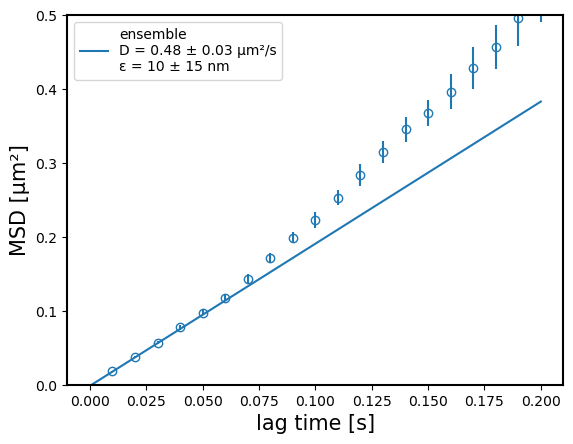

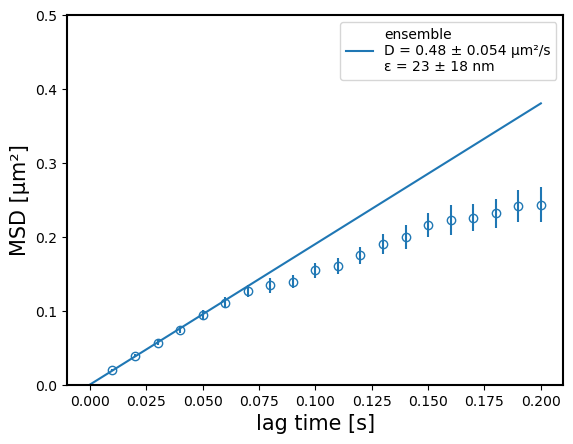

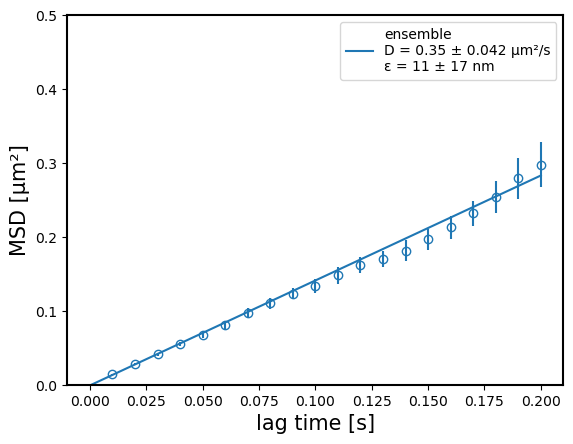

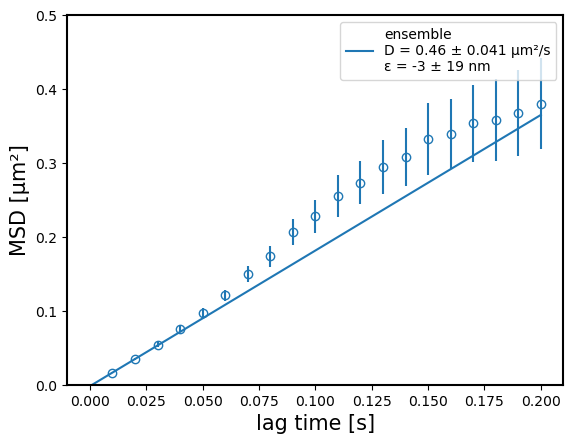

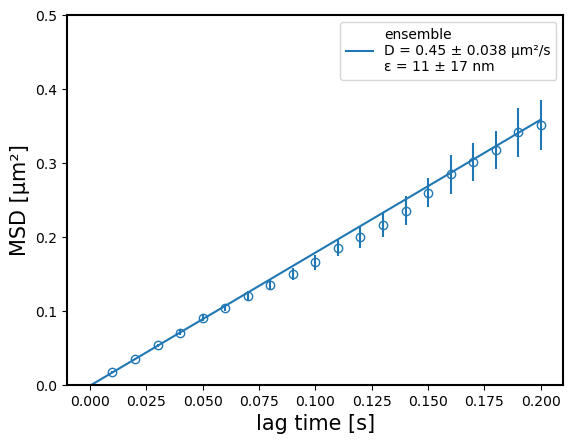

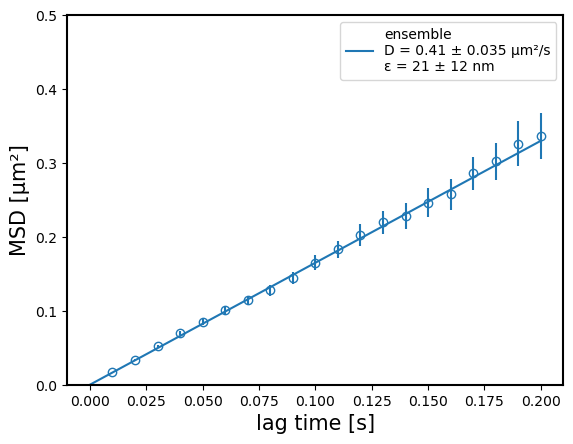

In [71]:
for i in range(0, len(filenames)):

    fig, ax = plt.subplots()

    msd_ens[i].plot(ax=ax)
    plt.ylim((0,0.5))

    
    
    fig.savefig(f'{data_dir}/'+filenames[i]+"_MSD.png")
 

## MSD analysis: different spots in one well

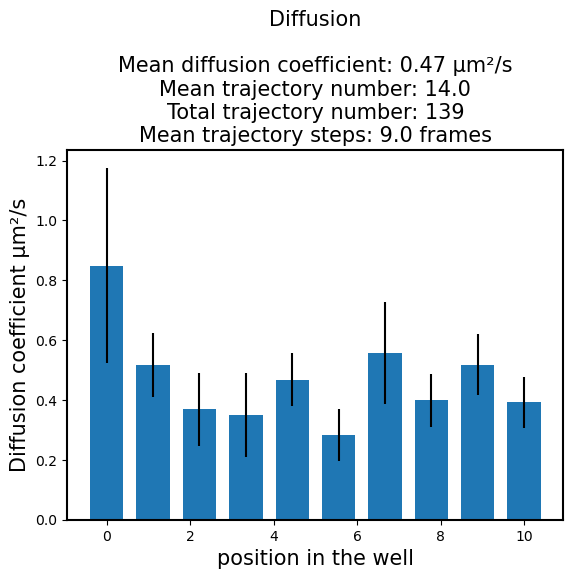

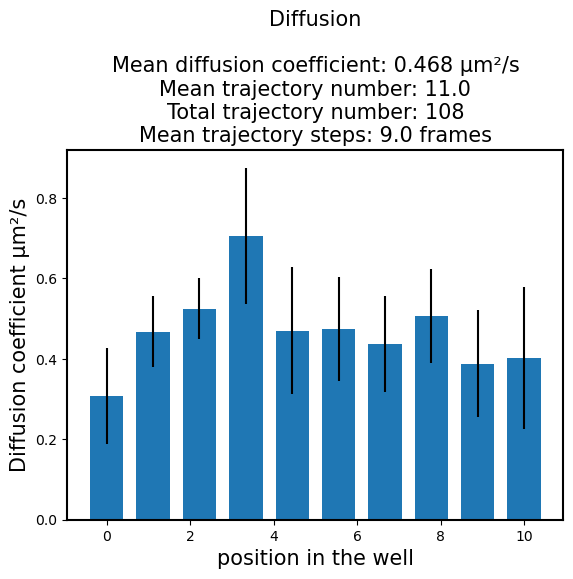

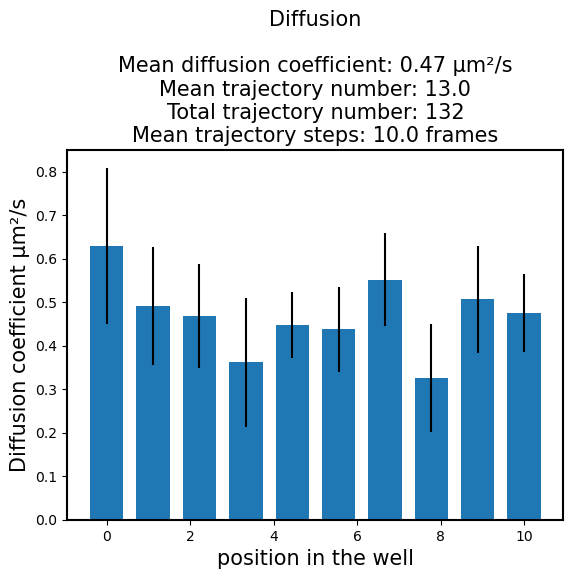

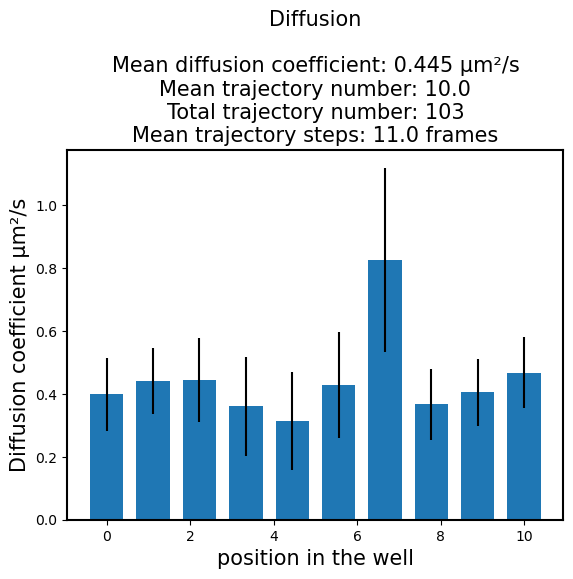

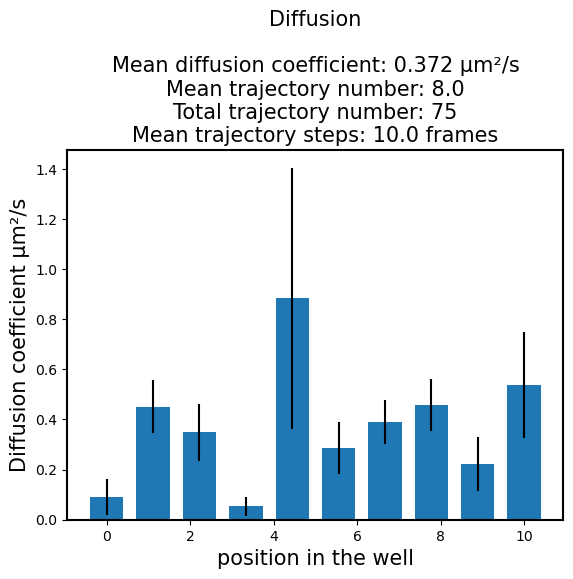

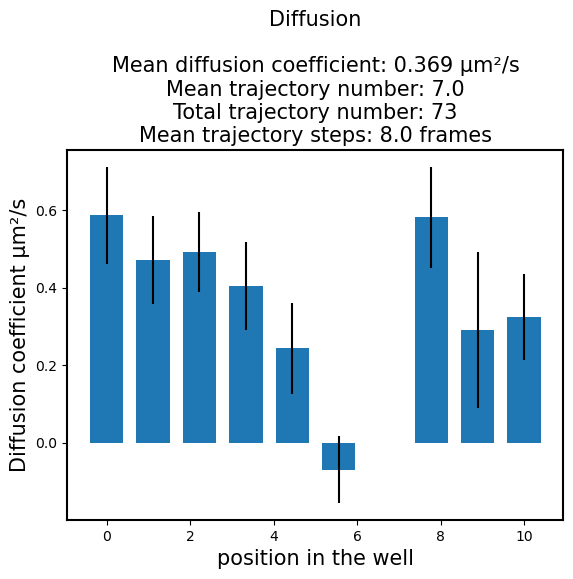

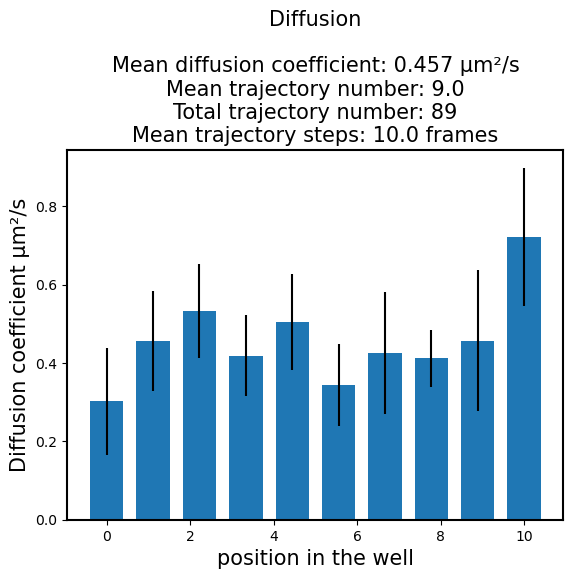

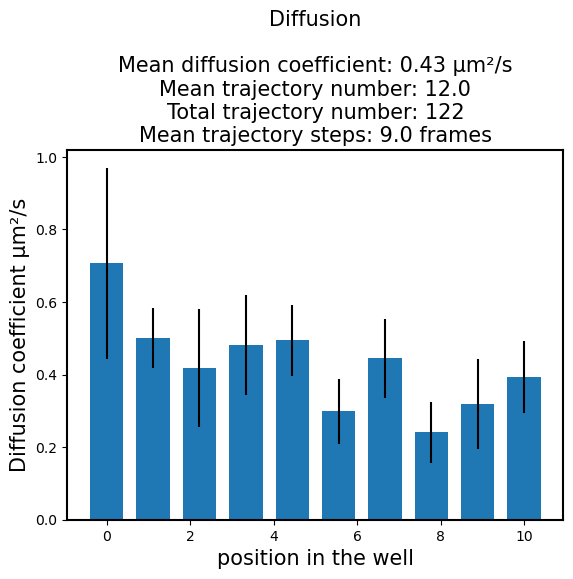

In [72]:
diffusion=[]
for i in range(0, len(filenames)):
    
    D,D_err,eps,eps_err=[],[],[],[]
    
    for g in trc[i]:

        msd_ens = motion.Msd(g, fps, pixel_size=pixel_size, ensemble=True).fit("brownian", exposure_time=exp_time)
        
        D.append(msd_ens.get_results()[0]['D'])
        eps.append(msd_ens.get_results()[0]['eps'])
        D_err.append(msd_ens.get_results()[1]['D'])
        eps_err.append(msd_ens.get_results()[1]['eps'])
        
#pd dataframe to save the data
    a,d=[],[]
    a=get_traj_parameters(trc[i])   
    d = {'D': D, 'D_err': D_err, 'eps':eps,'eps_err':eps_err, 'particles':a[0],'length [µm]':a[1],'frames':a[2]}
    diffusion=(pd.DataFrame(data=d))
    #neuuu
    # Direkt nach Erstellen des DataFrames diffusion:
    if i == 0:
        diffusion_list = []
    diffusion_list.append(diffusion)
    #neuuu
    #plot    
    fig, ax = plt.subplots()
    
    x_bar=np.linspace(0,len(trc[i]),len(trc[i]))
    plt.bar(x_bar,diffusion['D'])
    plt.errorbar(x_bar,diffusion['D'], yerr=diffusion['D_err'], marker='',ls='',ecolor='black', color='grey')
    

    ax.set(xlabel='position in the well', ylabel='Diffusion coefficient µm\u00b2/s')
    
    plt.title('Diffusion\n\n'+'Mean diffusion coefficient: '+str(np.round(np.mean(diffusion['D']),3))+' µm\u00b2/s\n'
          +'Mean trajectory number: '+str(np.round(np.mean(diffusion['particles'])))+'\n'
          +'Total trajectory number: '+str(np.round(np.sum(diffusion['particles'])))+'\n'
          +'Mean trajectory steps: '+str(np.round(np.mean(diffusion['frames'])))+ ' frames')
              
    fig.savefig(f'{data_dir}/'+filenames[i]+"_MSDperPosition.png",bbox_inches='tight')
 

## MSD analysis: individual diffusion coefficients

### Population of diffusion coefficients

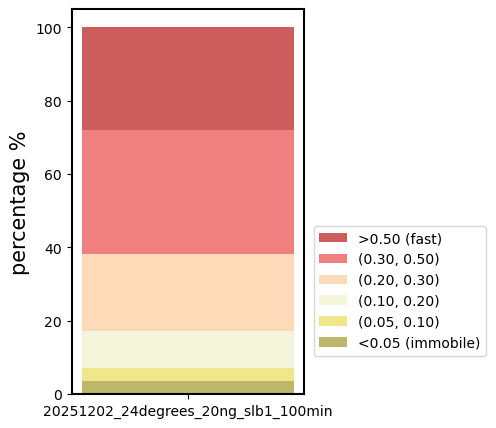

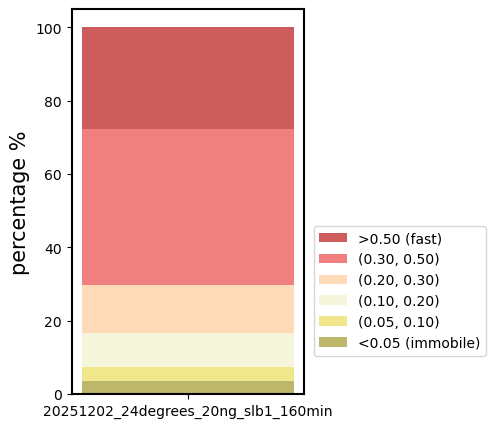

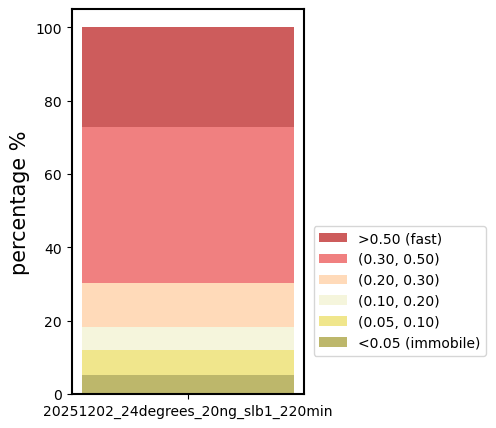

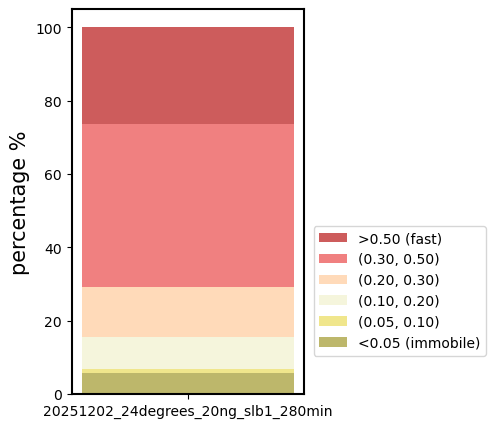

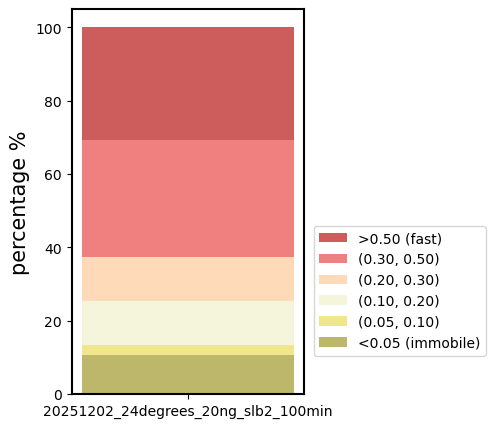

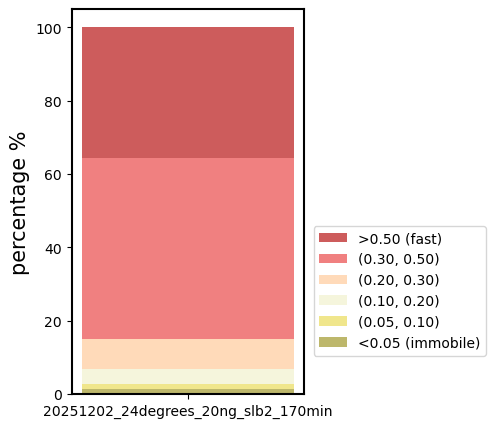

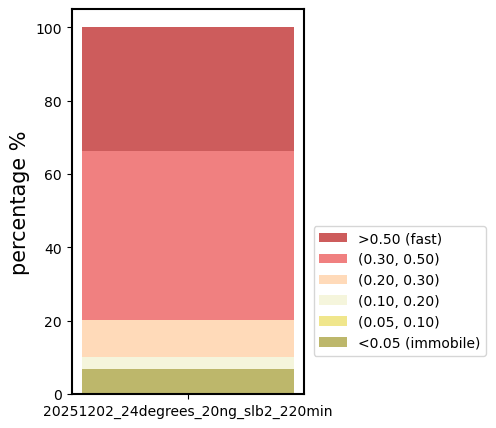

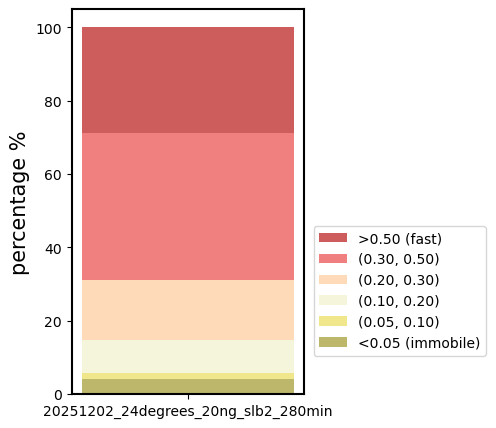

In [73]:
for i in range(0, len(filenames)):


    t, err = fit_ind[i].get_results()

    immob_perc = len(np.log(t['D'])[np.log(t['D']) < immob_thresh])/len(np.log(t['D']))
    super_slow_perc = len(np.log(t['D'])[(np.log(t['D']) < super_slow_tresh)&(np.log(t['D'])>= immob_thresh)])/len(np.log(t['D']))
    slow_perc = len(np.log(t['D'])[(np.log(t['D']) < slow_tresh)&(np.log(t['D'])>= super_slow_tresh)])/len(np.log(t['D']))
    normal_perc = len(np.log(t['D'])[(np.log(t['D']) < normal_tresh)&(np.log(t['D'])>= slow_tresh)])/len(np.log(t['D'])) 
    middle_perc = len(np.log(t['D'])[(np.log(t['D']) < fast_tresh)&(np.log(t['D'])>= normal_tresh)])/len(np.log(t['D']))
    fast_perc = len(np.log(t['D'])[(np.log(t['D'])>= fast_tresh)])/len(np.log(t['D']))
    rest=100*(immob_perc+slow_perc+super_slow_perc+normal_perc+fast_perc)

    if i == 0:
        immob_perc_list = []
        super_slow_perc_list = []
        slow_perc_list = []
        normal_perc_list = []
        middle_perc_list = []
        fast_perc_list = []
        rest_list = []
        
    immob_perc_list.append(immob_perc)
    super_slow_perc_list.append(super_slow_perc)
    slow_perc_list.append(slow_perc)
    normal_perc_list.append(normal_perc)
    middle_perc_list.append(middle_perc)
    fast_perc_list.append(fast_perc)
    rest_list.append(rest)
    
    
#plot population
    fig, ax = plt.subplots(figsize=(3,5))

#name of the sample
    x=filenames[i]


    #rest=100*(immob_perc+slow_perc+super_slow_perc+normal_perc+fast_perc)
    plt.bar(x,100-rest ,bottom=rest,label=label_fast,color='indianred')
    plt.bar(x, 100*fast_perc ,bottom=100*(immob_perc+slow_perc+normal_perc+super_slow_perc),label=label_middle,color='lightcoral')
    plt.bar(x,100*normal_perc ,bottom=100*(immob_perc+slow_perc+super_slow_perc),label=label_normal, color='peachpuff')
    plt.bar(x,100*slow_perc ,bottom=100*(immob_perc+super_slow_perc),label=label_slow, color='beige')
    plt.bar(x, 100*super_slow_perc ,bottom=100*immob_perc,label=label_superslow ,color='khaki')
    plt.bar(x, immob_perc*100, label=label_immobile, color='darkkhaki')

   
    plt.ylabel('percentage %')
    plt.legend(loc=(1.04, 0.1))

    fig.savefig(f'{data_dir}/'+filenames[i]+"_population.png",bbox_inches = "tight")
 


### Brightness and frames 

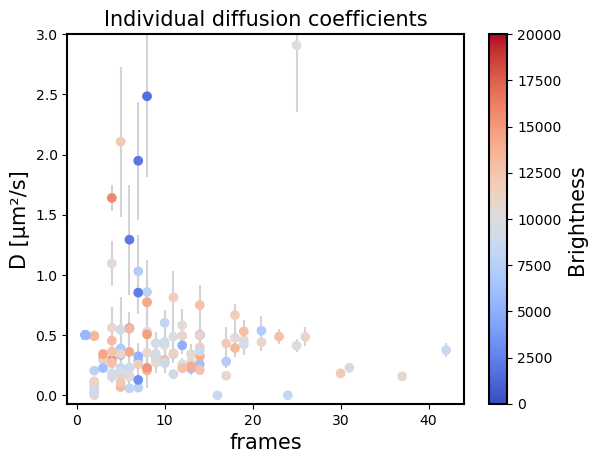

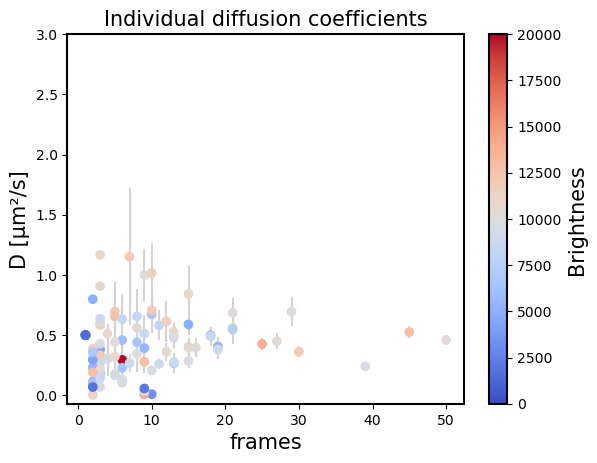

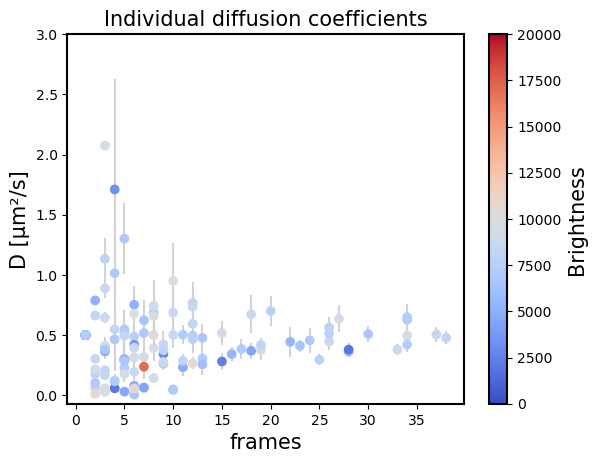

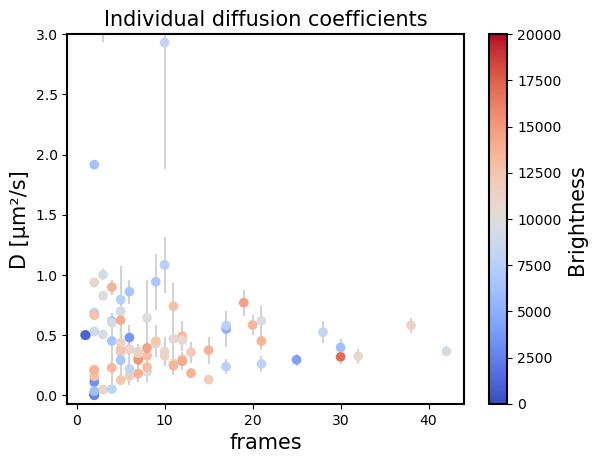

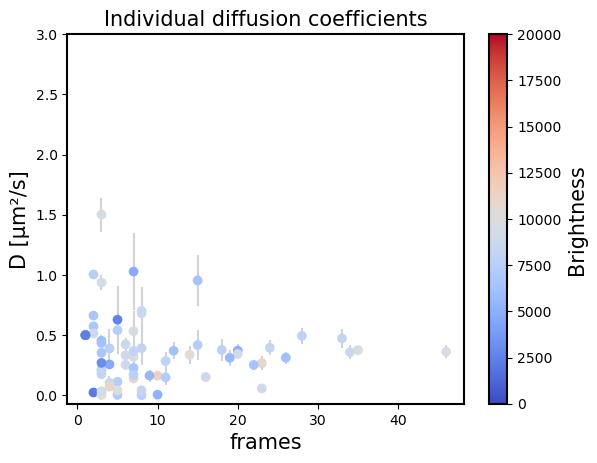

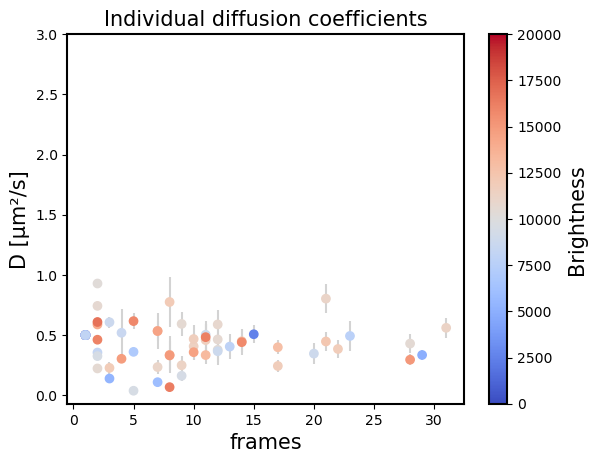

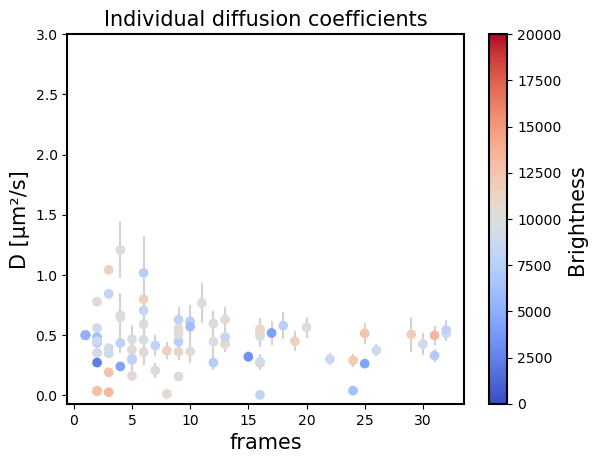

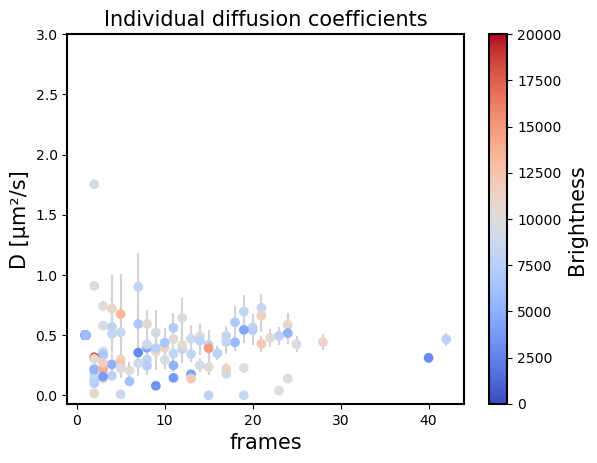

In [74]:
for i in range(0, len(filenames)):
    D_ind=fit_ind[i].get_results()[0]['D']
    D_err_ind=fit_ind[i].get_results()[1]['D']

    steps, steps_norm, mass, diffusion_ind=[],[],[], []

    for l in range(0,len(trc[i])):
    
        steps.append(get_traj_steps(trc[i][l]))
        ma=trc[i][l].drop_duplicates('particle')
        mass.append(ma['mass'].to_numpy())

# create a dataframe
        d_ind = {'D': D_ind[l], 'D_err': D_err_ind[l], 'steps':steps[l], 'mass':mass[l]}
        diffusion_ind.append(pd.DataFrame(data=d_ind))
        
#plot 
    fig, ax = plt.subplots()
    for k in range(0,len(diffusion_ind)):
        plt.scatter( diffusion_ind[k]['steps'],diffusion_ind[k]['D'], c=diffusion_ind[k]['mass'], cmap='coolwarm',vmin=0, vmax=20000, zorder=1)
        plt.errorbar(diffusion_ind[k]['steps'],diffusion_ind[k]['D'],yerr = diffusion_ind[k]['D_err'], marker='',ls='',ecolor='lightgray',zorder=0)

        plt.ylim((-0.07,3))
        
    plt.colorbar(label="Brightness", orientation="vertical")
    plt.xlabel('frames')
    plt.ylabel('D [µm\u00b2/s]')
    plt.title('Individual diffusion coefficients')
    fig.savefig(f'{data_dir}/'+filenames[i]+"_Brightness.png",bbox_inches='tight')
 

  0%|          | 0/8 [00:00<?, ?it/s]

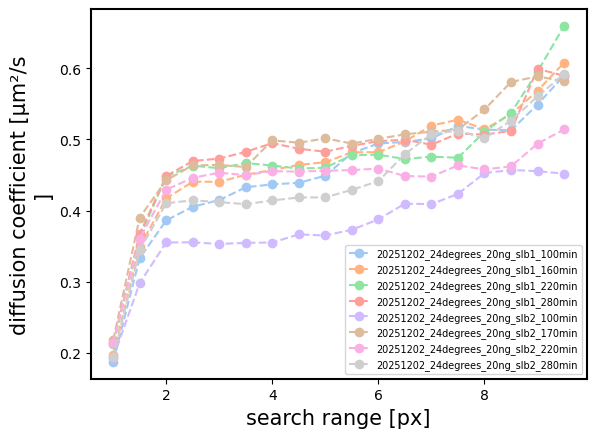

In [75]:
first_frame_for_check=10

def search_range_check(data_brightness, data_files_brightness_filename, data_loc_brightness, memory, fps, pixel_size,exp_time):
    range_list=np.arange(1,10,0.5)
    cols=sns.color_palette("pastel", n_colors=len(data_files_brightness_filename))


    fig, ax = plt.subplots()

    for j in tqdm(range(0,len(data_files_brightness_filename))):
        dcoef=[]
    
        for i in range_list:
            trc = [trackpy.link(d[d['frame'] >= first_frame_for_check], search_range=i, memory=memory) for d in data_loc_brightness[j]]
            m = motion.Msd(trc, frame_rate=fps, pixel_size=pixel_size)
            f = m.fit("brownian", n_lag=2, exposure_time=exp_time)
            fit, fit_err = f.get_results()
            dcoef.append((fit.iloc[0]))


        plt.plot(range_list,dcoef, '--o', color=cols[j], label=data_files_brightness_filename[j])

    plt.xlabel('search range [px]')
    plt.ylabel('diffusion coefficient [µm\u00b2/s\n]')
    plt.legend(fontsize=7)
    
    fig.savefig(f'{data_brightness}/'+"_search_range_test.png",bbox_inches='tight')
    plt.close(fig)

    return fig

search_range_check(data_brightness=data_dir, data_files_brightness_filename=filenames, data_loc_brightness=data_loc, memory=memory, fps=fps, pixel_size=pixel_size, exp_time=exp_time)

In [77]:
data_dir

'/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/37vs26degrees/origami_37vs26degrees_L1_1202_1204/20251204_origami_24/20ng'

/var/folders/_z/fj6p1tzs10j6cmtrm_v7mh8h0000gn/T/ipykernel_19971/2781967398.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(data_groups))


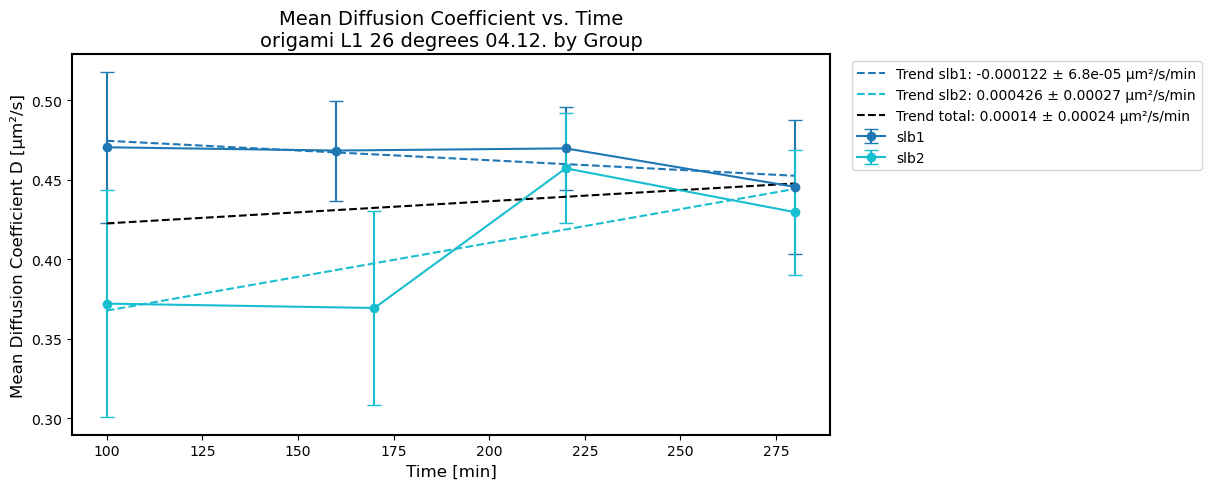

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
import os

# Zeitpunkte und Mittelwerte sammeln
data_groups = ['slb1', 'slb2']
custom_title = "origami L1 26 degrees 04.12."
times = []
mean_D = []
sem_D = []
groupnames = []

# Gruppenzuordnung 
for filename in filenames:
    group = next((g for g in data_groups if g in filename), None)
    groupnames.append(group)

# Werte sammeln
for i, filename in enumerate(filenames):
    # Zeit aus Dateiname holen
    m = re.search(r'_(\d+)min', filename)
    if m:
        times.append(int(m.group(1)))
    else:
        times.append(np.nan)

    # Mittelwert und SEM berechnen
    Ds = diffusion_list[i]['D'].to_numpy()
    mean_D.append(np.nanmean(Ds))
    sem_D.append(np.nanstd(Ds)/np.sqrt(len(Ds)) if len(Ds) > 0 else np.nan)

times = np.array(times)
mean_D = np.array(mean_D)
sem_D = np.array(sem_D)
groupnames = np.array(groupnames)

# Farben automatisch
cmap = cm.get_cmap('tab10', len(data_groups))
colors = {g: cmap(i) for i, g in enumerate(data_groups)}

plt.figure(figsize=(15, 5))  # Mehr Platz

for i, group in enumerate(data_groups):
    mask = (groupnames == group)
    if np.sum(mask) == 0:
        continue
    group_times = times[mask]
    group_mean_D = mean_D[mask]
    group_sem_D = sem_D[mask]
    sort_idx = np.argsort(group_times)
    group_times = group_times[sort_idx]
    group_mean_D = group_mean_D[sort_idx]
    group_sem_D = group_sem_D[sort_idx]
    
    plt.errorbar(
        group_times, group_mean_D, yerr=group_sem_D, fmt='o-', 
        capsize=5, label=group, color=colors[group]
    )
    if np.sum(~np.isnan(group_mean_D)) >= 2:
        coef, cov = np.polyfit(group_times, group_mean_D, 1, cov=True)
        p = np.poly1d(coef)
        x_fit = np.linspace(np.nanmin(group_times), np.nanmax(group_times), 100)
        y_fit = p(x_fit)
        slope = coef[0]
        slope_err = np.sqrt(cov[0,0])
        trend_label = f"Trend {group}: {slope:.3g} ± {slope_err:.2g} µm²/s/min"
        plt.plot(x_fit, y_fit, '--', color=colors[group], label=trend_label)
        
# Gesamtrend berechnen
coef, cov = np.polyfit(times, mean_D, 1, cov=True)
p = np.poly1d(coef)
x_fit = np.linspace(np.nanmin(times), np.nanmax(times), 100)
y_fit = p(x_fit)
slope = coef[0]
slope_err = np.sqrt(cov[0,0])
trend_label = f"Trend total: {slope:.3g} ± {slope_err:.2g} µm²/s/min"
plt.plot(x_fit, y_fit, '--', color='black', label=trend_label)

plt.xlabel("Time [min]", fontsize=12)
plt.ylabel("Mean Diffusion Coefficient D [µm²/s]", fontsize=12)
plt.title(f"Mean Diffusion Coefficient vs. Time\n{custom_title} by Group", fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, fontsize=10)
plt.tight_layout(rect=[0, 0, 0.82, 1])  # Platz für Legende

save_dir = f'{data_dir}/plots'
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, "Mean_D_vs_Time_by_group.png"), bbox_inches='tight')
plt.show()

MEMORY-EFFICIENT TIME COURSE ANALYSIS
✓ Grouped input detected
  Groups: 2
    - 20ng origami L1 04.12. slb1: 4 files
    - 20ng origami L1 04.12. slb2: 4 files
  Total: 8 files
  System mode: 4GB RAM (individual processing)

[1/8] 20ng origami L1 04.12. slb1 | 20251202_24degrees_20ng_slb1_100min
  → D = 0.4604 ± 0.0417 µm²/s
[2/8] 20ng origami L1 04.12. slb1 | 20251202_24degrees_20ng_slb1_160min
  → D = 0.4761 ± 0.0312 µm²/s
[3/8] 20ng origami L1 04.12. slb1 | 20251202_24degrees_20ng_slb1_220min
  → D = 0.4841 ± 0.0280 µm²/s
[4/8] 20ng origami L1 04.12. slb1 | 20251202_24degrees_20ng_slb1_280min
  → D = 0.4466 ± 0.0451 µm²/s
[5/8] 20ng origami L1 04.12. slb2 | 20251202_24degrees_20ng_slb2_100min
  → D = 0.3687 ± 0.0675 µm²/s
[6/8] 20ng origami L1 04.12. slb2 | 20251202_24degrees_20ng_slb2_170min
  → D = 0.4156 ± 0.0446 µm²/s
[7/8] 20ng origami L1 04.12. slb2 | 20251202_24degrees_20ng_slb2_220min
  → D = 0.4602 ± 0.0324 µm²/s
[8/8] 20ng origami L1 04.12. slb2 | 20251202_24degrees_20ng_

/var/folders/_z/fj6p1tzs10j6cmtrm_v7mh8h0000gn/T/ipykernel_19971/541250493.py:279: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(group_names))



✓ Plot saved: /Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/37vs26degrees/origami_37vs26degrees_L1_1202_1204/20251204_origami_24/20ng/plots/Mean_D_vs_Time_by_group.png


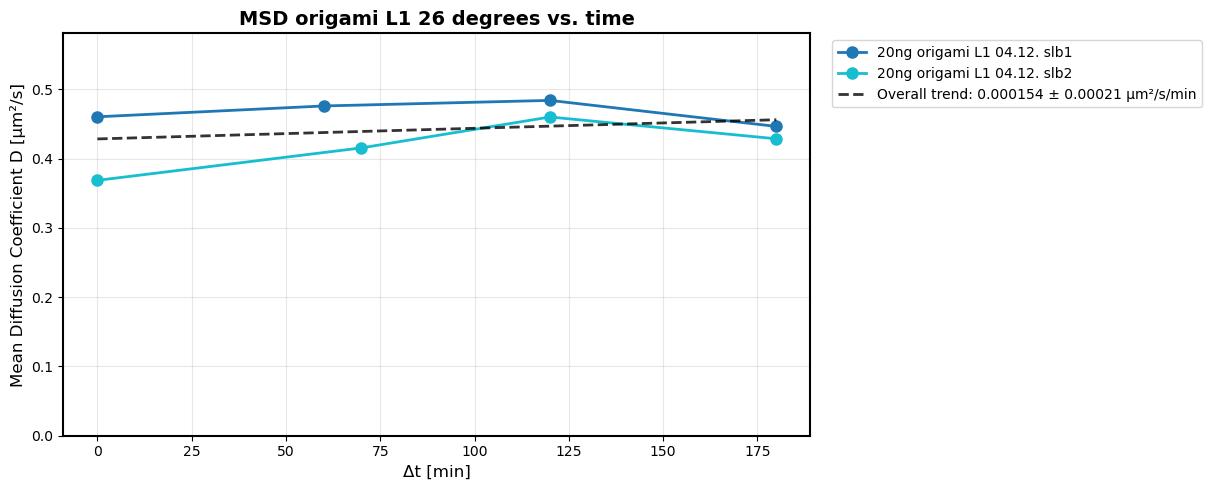


Creating normalized plot...


/var/folders/_z/fj6p1tzs10j6cmtrm_v7mh8h0000gn/T/ipykernel_19971/541250493.py:363: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(group_names))


✓ Normalized plot saved: /Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/37vs26degrees/origami_37vs26degrees_L1_1202_1204/20251204_origami_24/20ng/plots/Mean_D_vs_Time_normalized.png


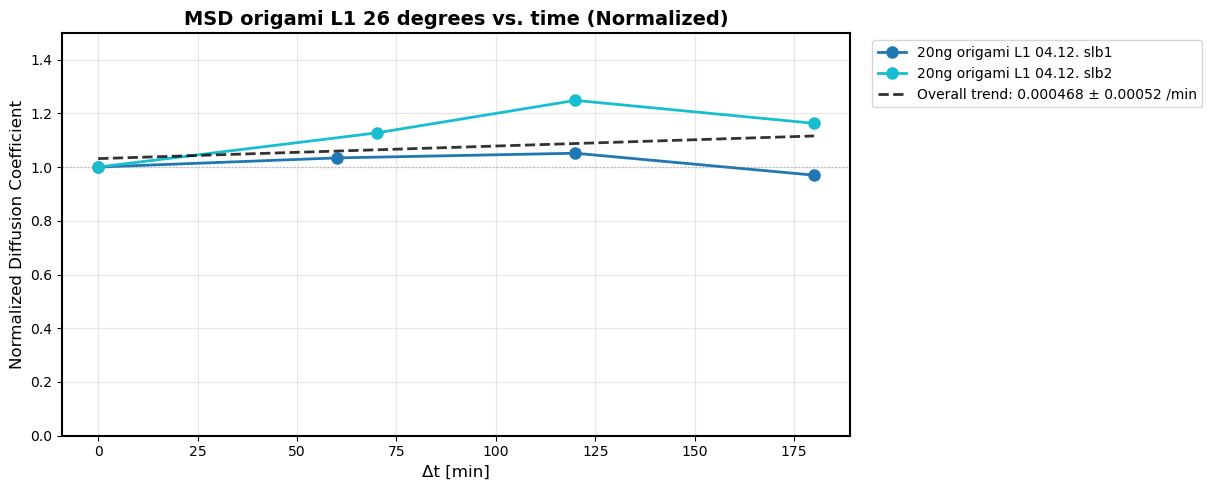


✓ ALL STEPS COMPLETED SUCCESSFULLY!


In [81]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
import os
import gc
from tqdm.notebook import tqdm

# Import only essentials
from sdt import io, motion
import trackpy
trackpy.quiet()

# ==================== CONFIGURATION ====================
# Enter your parameters here:
data_dir = r'/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/37vs26degrees/origami_37vs26degrees_L1_1202_1204/20251204_origami_24/20ng'

# OPTION 1: Gruppierte Angabe (empfohlen!)

# Jede Liste = eine Gruppe, in gleicher Reihenfolge wie group_names

filenames = [

# Gruppe 1: slb1

    ['20251202_24degrees_20ng_slb1_100min', '20251202_24degrees_20ng_slb1_160min', '20251202_24degrees_20ng_slb1_220min', '20251202_24degrees_20ng_slb1_280min'],
    ['20251202_24degrees_20ng_slb2_100min', '20251202_24degrees_20ng_slb2_170min', '20251202_24degrees_20ng_slb2_220min', '20251202_24degrees_20ng_slb2_280min']
]

# Gruppennamen in gleicher Reihenfolge

group_names = ['20ng origami L1 04.12. slb1', '20ng origami L1 04.12. slb2']

# OPTION 2: Flat list (old method)

# If you use this, groups will be extracted from filenames

# filenames = ['file1_120min', 'file2_190min', ...]

# group_names = ['slb1', 'slb2']  # Strings to search for in filename

custom_title = "MSD origami L1 26 degrees vs. time"

# Imaging parameters
pixel_size = 0.16  # µm
exp_time = 0.003  # s
t_del = 0.007  # s
fps = 1/(t_del + exp_time)

# Tracking parameters
search_range = 4
memory = 2
min_track_length = 1
first_frame = 30

# ==================== HELPER FUNCTIONS ====================
def extract_time_from_filename(filename):
    """Extract timepoint from filename"""
    m = re.search(r'_(\d+)min', filename)
    return int(m.group(1)) if m else np.nan


def min_track_filter(tracks_list, min_track_length=1):
    """Filter trajectories by minimum length"""
    if isinstance(tracks_list, list):
        filtered = []
        for df in tracks_list:
            track_counts = df.groupby('particle').size()
            valid_particles = track_counts[track_counts >= min_track_length].index
            filtered.append(df[df['particle'].isin(valid_particles)])
        return filtered
    else:
        track_counts = tracks_list.groupby('particle').size()
        valid_particles = track_counts[track_counts >= min_track_length].index
        return tracks_list[tracks_list['particle'].isin(valid_particles)]


def calculate_diffusion_lightweight(filename, data_dir, pixel_size, fps, 
                                    exp_time, search_range, memory, 
                                    min_track_length, first_frame):
    """
    Calculate diffusion coefficient for one file with minimal memory usage.
    Returns only mean and SEM.
    """
    try:
        # Load only .h5 files (no images!)
        data_files = sorted(Path(data_dir).glob(f'**/{filename}*.h5'))
        
        if not data_files:
            print(f"⚠️  No .h5 files found for {filename}")
            return np.nan, np.nan
        
        # Load localizations
        data_loc = [io.load(f) for f in data_files]
        
        # Tracking - only on filtered frame range
        trc_all = []
        for loc_data in data_loc:
            filtered = loc_data[loc_data['frame'] > first_frame]
            tracked = trackpy.link(filtered, search_range=search_range, memory=memory)
            trc_all.append(tracked)
        
        # Filter by minimum length
        trc_filtered = min_track_filter(trc_all, min_track_length=min_track_length)
        
        # Calculate diffusion for each position
        D_values = []
        for trajectory in trc_filtered:
            if len(trajectory) < 2:
                continue
                
            try:
                msd = motion.Msd(trajectory, fps, pixel_size=pixel_size, ensemble=True)
                fit_result = msd.fit("brownian", exposure_time=exp_time)
                D = fit_result.get_results()[0]['D']
                
                # Only realistic values
                if 0 < D < 10:  # µm²/s
                    D_values.append(D)
            except:
                continue
        
        # Calculate statistics
        if len(D_values) > 0:
            mean_D = np.nanmean(D_values)
            sem_D = np.nanstd(D_values) / np.sqrt(len(D_values))
        else:
            mean_D = np.nan
            sem_D = np.nan
        
        # Free memory
        del data_loc, trc_all, trc_filtered
        gc.collect()
        
        return mean_D, sem_D
        
    except Exception as e:
        print(f"❌ Error for {filename}: {e}")
        return np.nan, np.nan


def flatten_grouped_filenames(filenames_grouped, group_names):
    """
    Convert grouped filenames to flat lists.
    
    Returns:
    --------
    filenames_flat : list
        Flat list of all filenames
    groupnames_flat : list
        Corresponding group assignment
    """
    filenames_flat = []
    groupnames_flat = []
    
    for group_idx, file_list in enumerate(filenames_grouped):
        group_name = group_names[group_idx]
        for filename in file_list:
            filenames_flat.append(filename)
            groupnames_flat.append(group_name)
    
    return filenames_flat, groupnames_flat


# ==================== MAIN ANALYSIS ====================
def analyze_timecourse(data_dir, filenames, group_names, custom_title,
                       pixel_size, fps, exp_time, search_range, memory,
                       min_track_length, first_frame):
    """
    Analyze time course with minimal memory usage.
    
    Parameters:
    -----------
    filenames : list of lists OR flat list
        Either grouped [[group1], [group2]] or flat [file1, file2, ...]
    group_names : list
        For grouped filenames: names of groups in same order
        For flat list: strings to search for in filename
    """
    
    print("="*60)
    print("MEMORY-EFFICIENT TIME COURSE ANALYSIS")
    print("="*60)
    
    # Check input format
    is_grouped = isinstance(filenames[0], list)
    
    if is_grouped:
        print("✓ Grouped input detected")
        filenames_flat, groupnames_flat = flatten_grouped_filenames(filenames, group_names)
        print(f"  Groups: {len(group_names)}")
        for i, (name, files) in enumerate(zip(group_names, filenames)):
            print(f"    - {name}: {len(files)} files")
    else:
        print("✓ Flat list detected - extracting groups from filenames")
        filenames_flat = filenames
        groupnames_flat = []
        for fname in filenames_flat:
            group = next((g for g in group_names if g in fname), None)
            groupnames_flat.append(group)
    
    print(f"  Total: {len(filenames_flat)} files")
    print(f"  System mode: 4GB RAM (individual processing)")
    print("="*60 + "\n")
    
    # Collect results
    times = []
    mean_D = []
    sem_D = []
    
    # Process each file individually
    total_files = len(filenames_flat)
    for i, (filename, group) in enumerate(zip(filenames_flat, groupnames_flat)):
        print(f"[{i+1}/{total_files}] {group:10s} | {filename}")
        
        # Extract time
        time = extract_time_from_filename(filename)
        times.append(time)
        
        # Calculate diffusion (memory efficient)
        mean, sem = calculate_diffusion_lightweight(
            filename, data_dir, pixel_size, fps, exp_time,
            search_range, memory, min_track_length, first_frame
        )
        
        mean_D.append(mean)
        sem_D.append(sem)
        
        print(f"  → D = {mean:.4f} ± {sem:.4f} µm²/s")
        
        # Explicit memory cleanup
        gc.collect()
    
    # Convert to arrays
    times = np.array(times)
    mean_D = np.array(mean_D)
    sem_D = np.array(sem_D)
    groupnames = np.array(groupnames_flat)
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETED")
    print("="*60)
    
    return times, mean_D, sem_D, groupnames, group_names


# ==================== PLOTTING ====================
def normalize_times_per_group(times, groupnames, group_names):
    """
    Set first timepoint of each group to 0 and calculate relative times.
    
    Returns:
    --------
    times_relative : array
        Times relative to first timepoint of each group
    """
    times_relative = np.copy(times)
    
    for group in group_names:
        mask = (groupnames == group) & (~np.isnan(times))
        if np.sum(mask) > 0:
            group_times = times[mask]
            first_time = np.nanmin(group_times)
            times_relative[mask] = times[mask] - first_time
    
    return times_relative


def plot_timecourse(times, mean_D, sem_D, groupnames, group_names, 
                    custom_title, data_dir):
    """Create time course plot with single overall trend line"""
    
    # Normalize times per group (first timepoint = 0)
    times_relative = normalize_times_per_group(times, groupnames, group_names)
    
    # Colors
    cmap = cm.get_cmap('tab10', len(group_names))
    colors = {g: cmap(i) for i, g in enumerate(group_names)}
    
    # Create plot
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Plot for each group (data points only, no error bars)
    for group in group_names:
        mask = (groupnames == group) & (~np.isnan(mean_D))
        
        if np.sum(mask) == 0:
            print(f"⚠️  No data for group '{group}'")
            continue
        
        group_times = times_relative[mask]
        group_mean_D = mean_D[mask]
        
        # Sort by time
        sort_idx = np.argsort(group_times)
        group_times = group_times[sort_idx]
        group_mean_D = group_mean_D[sort_idx]
        
        # Data points (no error bars)
        ax.plot(
            group_times, group_mean_D, 
            'o-', label=group, 
            color=colors[group], markersize=8, linewidth=2
        )
    
    # Overall trend (only non-NaN values)
    valid_mask = ~np.isnan(mean_D)
    if np.sum(valid_mask) >= 2:
        coef, cov = np.polyfit(times_relative[valid_mask], mean_D[valid_mask], 1, cov=True)
        p = np.poly1d(coef)
        x_fit = np.linspace(np.nanmin(times_relative[valid_mask]), 
                           np.nanmax(times_relative[valid_mask]), 100)
        y_fit = p(x_fit)
        
        slope = coef[0]
        slope_err = np.sqrt(cov[0,0])
        trend_label = f"Overall trend: {slope:.3g} ± {slope_err:.2g} µm²/s/min"
        
        ax.plot(x_fit, y_fit, '--', color='black', 
               label=trend_label, linewidth=2, alpha=0.8)
    
    # Set y-axis limits: 0 to 1.2 * max
    max_D = np.nanmax(mean_D[valid_mask])
    ax.set_ylim(0, 1.2 * max_D)
    
    # Formatting
    ax.set_xlabel("Δt [min]", fontsize=12)
    ax.set_ylabel("Mean Diffusion Coefficient D [µm²/s]", fontsize=12)
    ax.set_title(custom_title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), 
             frameon=True, fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    
    # Save
    save_dir = Path(data_dir) / 'plots'
    save_dir.mkdir(exist_ok=True)
    
    save_path = save_dir / "Mean_D_vs_Time_by_group.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    print(f"\n✓ Plot saved: {save_path}")
    
    plt.show()
    
    return fig


def plot_normalized_timecourse(times, mean_D, sem_D, groupnames, group_names, 
                               custom_title, data_dir):
    """
    Create normalized time course plot.
    Each group is normalized to its first datapoint (= 1).
    """
    
    # Normalize times per group (first timepoint = 0)
    times_relative = normalize_times_per_group(times, groupnames, group_names)
    
    # Colors
    cmap = cm.get_cmap('tab10', len(group_names))
    colors = {g: cmap(i) for i, g in enumerate(group_names)}
    
    # Create plot
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Collect all normalized data for overall trend and max calculation
    all_times_norm = []
    all_D_norm = []
    
    # Plot for each group (normalized to first datapoint)
    for group in group_names:
        mask = (groupnames == group) & (~np.isnan(mean_D))
        
        if np.sum(mask) == 0:
            print(f"⚠️  No data for group '{group}'")
            continue
        
        group_times = times_relative[mask]
        group_mean_D = mean_D[mask]
        
        # Sort by time
        sort_idx = np.argsort(group_times)
        group_times = group_times[sort_idx]
        group_mean_D = group_mean_D[sort_idx]
        
        # Normalize to first datapoint (= 1)
        first_D = group_mean_D[0]
        if first_D > 0:  # Avoid division by zero
            group_mean_D_norm = group_mean_D / first_D
            
            # Store for overall trend
            all_times_norm.extend(group_times)
            all_D_norm.extend(group_mean_D_norm)
            
            # Data points (no error bars)
            ax.plot(
                group_times, group_mean_D_norm, 
                'o-', label=group, 
                color=colors[group], markersize=8, linewidth=2
            )
    
    # Overall trend
    if len(all_times_norm) >= 2:
        all_times_norm = np.array(all_times_norm)
        all_D_norm = np.array(all_D_norm)
        
        coef, cov = np.polyfit(all_times_norm, all_D_norm, 1, cov=True)
        p = np.poly1d(coef)
        x_fit = np.linspace(np.nanmin(all_times_norm), 
                           np.nanmax(all_times_norm), 100)
        y_fit = p(x_fit)
        
        slope = coef[0]
        slope_err = np.sqrt(cov[0,0])
        trend_label = f"Overall trend: {slope:.3g} ± {slope_err:.2g} /min"
        
        ax.plot(x_fit, y_fit, '--', color='black', 
               label=trend_label, linewidth=2, alpha=0.8)
    
    # Add horizontal line at 1
    ax.axhline(y=1, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Set y-axis limits: 0 to 1.2 * max
    max_D_norm = np.nanmax(all_D_norm)
    ax.set_ylim(0, 1.2 * max_D_norm)
    
    # Formatting
    ax.set_xlabel("Δt [min]", fontsize=12)
    ax.set_ylabel("Normalized Diffusion Coefficient", fontsize=12)
    ax.set_title(f"{custom_title} (Normalized)", fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), 
             frameon=True, fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    
    # Save
    save_dir = Path(data_dir) / 'plots'
    save_dir.mkdir(exist_ok=True)
    
    save_path = save_dir / "Mean_D_vs_Time_normalized.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    print(f"✓ Normalized plot saved: {save_path}")
    
    plt.show()
    
    return fig


# ==================== MAIN PROGRAM ====================
if __name__ == "__main__":
    
    # Run analysis
    times, mean_D, sem_D, groupnames, actual_group_names = analyze_timecourse(
        data_dir, filenames, group_names, custom_title,
        pixel_size, fps, exp_time, search_range, memory,
        min_track_length, first_frame
    )
    
    # Create absolute plot
    print("\n" + "="*60)
    print("Creating absolute plot...")
    print("="*60)
    fig1 = plot_timecourse(
        times, mean_D, sem_D, groupnames, 
        actual_group_names, custom_title, data_dir
    )
    
    # Create normalized plot
    print("\n" + "="*60)
    print("Creating normalized plot...")
    print("="*60)
    fig2 = plot_normalized_timecourse(
        times, mean_D, sem_D, groupnames, 
        actual_group_names, custom_title, data_dir
    )
    
    print("\n" + "="*60)
    print("✓ ALL STEPS COMPLETED SUCCESSFULLY!")
    print("="*60)

In [82]:
print(group_times)
save_dir

[100 170 220 280]


'/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/37vs26degrees/origami_37vs26degrees_L1_1202_1204/20251204_origami_24/20ng/plots'

In [83]:
print(times)

[100 160 220 280 100 170 220 280]


In [84]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

subpop_cmap = cm.get_cmap('Set1', 6)

# Intervall + Name
intervals = [
    '<0.05',
    '(0.05, 0.10)',
    '(0.10, 0.20)',
    '(0.20, 0.30)',
    '(0.30, 0.50)',
    '>0.50'
]
typenames = [
    'immobile',
    'superslow',
    'slow',
    'normal',
    'middle',
    'fast'
]
pop_lists = [
    immob_perc_list,
    super_slow_perc_list,
    slow_perc_list,
    normal_perc_list,
    middle_perc_list,
    fast_perc_list
]

for g_idx, group in enumerate(data_groups):
    plt.figure(figsize=(10,6))
    mask = (np.array(groupnames) == group)
    if np.sum(mask) == 0:
        continue

    group_times = times[mask]
    sort_idx = np.argsort(group_times)
    group_times = group_times[sort_idx]

    for l_idx, (interval, typename, pop_list) in enumerate(zip(intervals, typenames, pop_lists)):
        perc = np.array(pop_list)[mask] * 100
        perc = perc[sort_idx]
        color = subpop_cmap(l_idx)
        
        # Label wie gewünscht
        line_label = f"{interval} {typename}"
        plt.plot(group_times, perc, marker='o', label=line_label, color=color)
        
        # Trendlinie und Label
        if np.sum(~np.isnan(perc)) >= 2:
            coef, cov = np.polyfit(group_times, perc, 1, cov=True)
            p = np.poly1d(coef)
            x_fit = np.linspace(np.nanmin(group_times), np.nanmax(group_times), 100)
            y_fit = p(x_fit)
            slope = coef[0]
            slope_err = np.sqrt(cov[0,0])
            trend_label = f"Trend {interval} {typename}: {slope:.2g} ± {slope_err:.1g} %/min"
            plt.plot(x_fit, y_fit, '--', color=color, alpha=0.8, label=trend_label)

    plt.xlabel("Time [min]")
    plt.ylabel("Population fraction [%]")
    plt.title(f"Population fractions of mobility classes over time\nGroup: {group}")
    plt.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), frameon=True, fontsize=9)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.grid(True)

    save_dir = f'{data_dir}/plots'
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"Population_Fractions_vs_Time_{group}_trends_named.png"), bbox_inches='tight')
    plt.show()


/var/folders/_z/fj6p1tzs10j6cmtrm_v7mh8h0000gn/T/ipykernel_19971/1105644211.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  subpop_cmap = cm.get_cmap('Set1', 6)


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

/var/folders/_z/fj6p1tzs10j6cmtrm_v7mh8h0000gn/T/ipykernel_19971/2850924013.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  subpop_cmap = cm.get_cmap('Set1', 6)


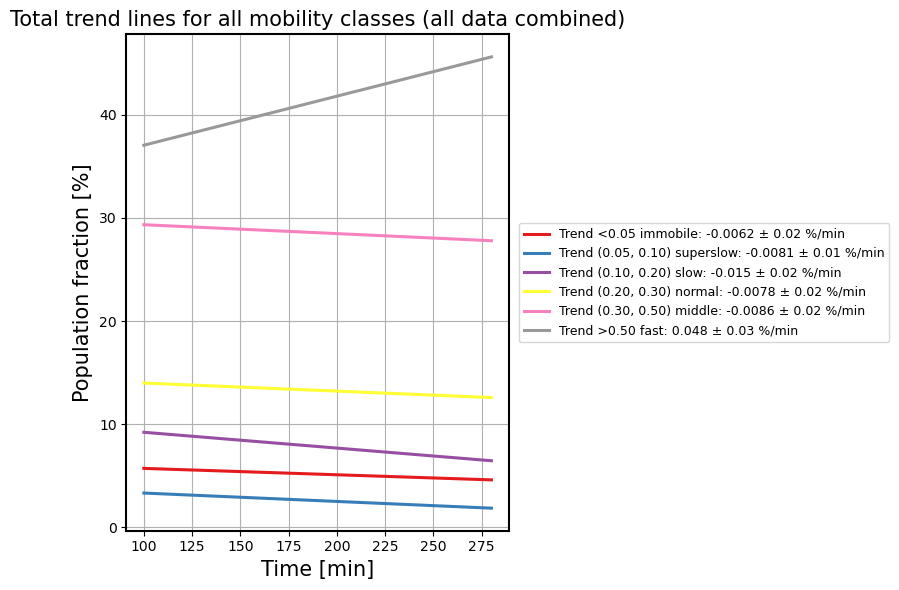

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

subpop_cmap = cm.get_cmap('Set1', 6)

intervals = [
    '<0.05',
    '(0.05, 0.10)',
    '(0.10, 0.20)',
    '(0.20, 0.30)',
    '(0.30, 0.50)',
    '>0.50'
]
typenames = [
    'immobile',
    'superslow',
    'slow',
    'normal',
    'middle',
    'fast'
]
pop_lists = [
    immob_perc_list,
    super_slow_perc_list,
    slow_perc_list,
    normal_perc_list,
    middle_perc_list,
    fast_perc_list
]

plt.figure(figsize=(10,6))

all_times = np.array(times)

for l_idx, (interval, typename, pop_list) in enumerate(zip(intervals, typenames, pop_lists)):
    color = subpop_cmap(l_idx)
    perc = np.array(pop_list) * 100
    valid_mask = ~np.isnan(perc) & ~np.isnan(all_times)
    if np.sum(valid_mask) >= 2:
        coef, cov = np.polyfit(all_times[valid_mask], perc[valid_mask], 1, cov=True)
        p = np.poly1d(coef)
        x_fit = np.linspace(np.nanmin(all_times[valid_mask]), np.nanmax(all_times[valid_mask]), 100)
        y_fit = p(x_fit)
        slope = coef[0]
        slope_err = np.sqrt(cov[0,0])
        label = f"Trend {interval} {typename}: {slope:.2g} ± {slope_err:.1g} %/min"
        plt.plot(x_fit, y_fit, '-', color=color, linewidth=2.2, label=label)

plt.xlabel("Time [min]")
plt.ylabel("Population fraction [%]")
plt.title("Total trend lines for all mobility classes (all data combined)")
plt.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), frameon=True, fontsize=9)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.grid(True)

save_dir = f'{data_dir}/plots'
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, "Population_TotalTrends_perClass.png"), bbox_inches='tight')
plt.show()
